# ISTAT FOI - Download and Merge FOI Data

This notebook downloads FOI (Famiglie e Operatori Istituzionali) data from ISTAT and merges them into a single file.

**Data sources:**
- 1996-2010: Base 1995=100
- 2011-2015: Base 2010=100
- 2016-2025: Base 2015=100

The notebook downloads the CSV files from ISTAT SDMX API and merges them into `data/istat/FOI_MONTHLY.csv` with columns:
- TIME_PERIOD: Date period (YYYY-MM format)
- OBS_VALUE: Observation value
- BASE: Base year indicator (1995=100, 2010=100, or 2015=100)


In [1]:
import pandas as pd
import os
import requests
from io import StringIO
import urllib3
import openpyxl  # For reading Excel files
import time

# Suppress SSL warnings (equivalent to curl -kL)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


In [2]:
# Function to download with retry
def download_with_retry(url, filepath, headers=None, max_retries=3, retry_delay=5, timeout=180):
    """
    Download a file with retry mechanism.
    
    Parameters:
    -----------
    url : str
        URL to download from
    filepath : str
        Path where to save the file
    headers : dict, optional
        HTTP headers to use
    max_retries : int
        Maximum number of retry attempts (default: 3)
    retry_delay : int
        Delay in seconds between retries (default: 5)
    timeout : int
        Request timeout in seconds (default: 180)
    
    Returns:
    --------
    bool : True if download successful, False otherwise
    """
    for attempt in range(1, max_retries + 1):
        try:
            print(f"  Attempt {attempt}/{max_retries}...")
            response = requests.get(url, headers=headers, verify=False, timeout=timeout)
            response.raise_for_status()
            
            # Save to file
            with open(filepath, 'wb') as f:
                f.write(response.content)
            
            print(f"  Download successful: {filepath}")
            print(f"  File size: {len(response.content)} bytes")
            return True
            
        except requests.exceptions.RequestException as e:
            print(f"  Attempt {attempt} failed: {e}")
            if attempt < max_retries:
                print(f"  Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"  All {max_retries} attempts failed for {url}")
                return False
    
    return False


In [3]:
# Change to project root directory
# Find the project root by looking for the 'data' directory
current_dir = os.getcwd()
while not os.path.exists(os.path.join(current_dir, 'data')):
    parent_dir = os.path.dirname(current_dir)
    if parent_dir == current_dir:
        # Reached filesystem root without finding 'data' directory
        raise FileNotFoundError("Could not find project root directory (looking for 'data' folder)")
    current_dir = parent_dir

os.chdir(current_dir)
print(f"Working directory: {os.getcwd()}")

# Define output directory
output_dir = 'data/istat'
os.makedirs(output_dir, exist_ok=True)

print(f"Output directory: {output_dir}")


Working directory: /workspace
Output directory: data/istat


In [4]:
# Define the URLs and corresponding base years
download_configs = [
    {
        'url': 'https://esploradati.istat.it/SDMXWS/rest/data/169_745_DF_DCSP_FOI1B2015_1/M.IT.55.4.00?startPeriod=2016-01&endPeriod=2025-12',
        'filename': 'foi_2016_2025.csv',
        'base': '2015=100'
    },
    {
        'url': 'https://esploradati.istat.it/SDMXWS/rest/data/144_110_DF_DCSP_FOI1_1/M.IT.4.4.00?startPeriod=1996-01&endPeriod=2010-12',
        'filename': 'foi_1996_2010_base1995.csv',
        'base': '1995=100'
    },
    {
        'url': 'https://esploradati.istat.it/SDMXWS/rest/data/169_15_DF_DCSP_FOI1B2010_1/M.IT.11.4.00?startPeriod=2011-01&endPeriod=2015-12',
        'filename': 'foi_2011_2015_base2010.csv',
        'base': '2010=100'
    }
]

print("Files to download:")
for config in download_configs:
    print(f"  {config['filename']} (Base: {config['base']})")


Files to download:
  foi_2016_2025.csv (Base: 2015=100)
  foi_1996_2010_base1995.csv (Base: 1995=100)
  foi_2011_2015_base2010.csv (Base: 2010=100)


In [5]:
# Download all CSV files
headers = {
    'Accept': 'application/vnd.sdmx.data+csv;version=1.0.0'
}

downloaded_files = []

for config in download_configs:
    print(f"\n{'='*60}")
    print(f"Downloading {config['filename']}...")
    print(f"{'='*60}")
    
    filepath = os.path.join(output_dir, config['filename'])
    
    # Download with retry mechanism
    success = download_with_retry(
        url=config['url'],
        filepath=filepath,
        headers=headers,
        max_retries=3,
        retry_delay=5,
        timeout=180
    )
    
    if success:
        downloaded_files.append({
            'filepath': filepath,
            'base': config['base']
        })
    else:
        print(f"Failed to download {config['filename']} after all retry attempts")

print(f"\n\nSuccessfully downloaded {len(downloaded_files)} file(s) out of {len(download_configs)}")



  Attempt 1/3...
  Download successful: data/istat/foi_2016_2025.csv
  File size: 9031 bytes

  Attempt 1/3...
  Download successful: data/istat/foi_1996_2010_base1995.csv
  File size: 12600 bytes

  Attempt 1/3...
  Download successful: data/istat/foi_2011_2015_base2010.csv
  File size: 4642 bytes


Successfully downloaded 3 file(s) out of 3


In [6]:
# Read and process each downloaded file
dataframes = []

for file_info in downloaded_files:
    filepath = file_info['filepath']
    base = file_info['base']
    
    print(f"\n{'='*60}")
    print(f"Processing {os.path.basename(filepath)} (Base: {base})...")
    print(f"{'='*60}")
    
    try:
        # Read the CSV file
        df = pd.read_csv(filepath)
        
        print(f"Original columns: {df.columns.tolist()}")
        print(f"Original shape: {df.shape}")
        print(f"\nFirst few rows:")
        print(df.head())
        
        # Check if TIME_PERIOD and OBS_VALUE columns exist
        if 'TIME_PERIOD' not in df.columns:
            print(f"Warning: TIME_PERIOD column not found. Available columns: {df.columns.tolist()}")
            # Try to find a similar column
            time_cols = [col for col in df.columns if 'TIME' in col.upper() or 'PERIOD' in col.upper() or 'DATE' in col.upper()]
            if time_cols:
                df = df.rename(columns={time_cols[0]: 'TIME_PERIOD'})
                print(f"Renamed '{time_cols[0]}' to 'TIME_PERIOD'")
            else:
                print("Error: Could not find TIME_PERIOD column")
                continue
        
        if 'OBS_VALUE' not in df.columns:
            print(f"Warning: OBS_VALUE column not found. Available columns: {df.columns.tolist()}")
            # Try to find a similar column
            obs_cols = [col for col in df.columns if 'OBS' in col.upper() or 'VALUE' in col.upper()]
            if obs_cols:
                df = df.rename(columns={obs_cols[0]: 'OBS_VALUE'})
                print(f"Renamed '{obs_cols[0]}' to 'OBS_VALUE'")
            else:
                print("Error: Could not find OBS_VALUE column")
                continue
        
        # Extract only TIME_PERIOD and OBS_VALUE
        df_extracted = df[['TIME_PERIOD', 'OBS_VALUE']].copy()
        
        # Add BASE column
        df_extracted['BASE'] = base
        
        # Convert OBS_VALUE to numeric
        df_extracted['OBS_VALUE'] = pd.to_numeric(df_extracted['OBS_VALUE'], errors='coerce')
        
        # Remove rows with missing values
        df_extracted = df_extracted.dropna()
        
        print(f"\nProcessed {len(df_extracted)} rows")
        print(f"Time period range: {df_extracted['TIME_PERIOD'].min()} to {df_extracted['TIME_PERIOD'].max()}")
        print(f"\nSample data:")
        print(df_extracted.head(10))
        
        dataframes.append(df_extracted)
        
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n\nSuccessfully processed {len(dataframes)} file(s)")



Processing foi_2016_2025.csv (Base: 2015=100)...
Original columns: ['DATAFLOW', 'FREQ', 'REF_AREA', 'DATA_TYPE', 'MEASURE', 'E_COICOP_REV_ISTAT', 'TIME_PERIOD', 'OBS_VALUE', 'OBS_STATUS', 'NOTE_DS', 'NOTE_REF_AREA', 'NOTE_DATA_TYPE', 'NOTE_MEASURE', 'NOTE_E_COICOP_REV_ISTAT', 'NOTE_TIME_PERIOD', 'BASE_PER', 'UNIT_MEAS', 'UNIT_MULT']
Original shape: (118, 18)

First few rows:
                               DATAFLOW FREQ REF_AREA  DATA_TYPE  MEASURE  \
0  IT1:169_745_DF_DCSP_FOI1B2015_1(1.0)    M       IT         55        4   
1  IT1:169_745_DF_DCSP_FOI1B2015_1(1.0)    M       IT         55        4   
2  IT1:169_745_DF_DCSP_FOI1B2015_1(1.0)    M       IT         55        4   
3  IT1:169_745_DF_DCSP_FOI1B2015_1(1.0)    M       IT         55        4   
4  IT1:169_745_DF_DCSP_FOI1B2015_1(1.0)    M       IT         55        4   

   E_COICOP_REV_ISTAT TIME_PERIOD  OBS_VALUE  OBS_STATUS  NOTE_DS  \
0                   0     2016-01       99.7         NaN      NaN   
1                   

In [7]:
# Merge all dataframes
if len(dataframes) > 0:
    print(f"\n{'='*60}")
    print("Merging all dataframes...")
    print(f"{'='*60}")
    
    # Concatenate all dataframes
    df_merged = pd.concat(dataframes, ignore_index=True)
    
    # Sort by TIME_PERIOD
    df_merged = df_merged.sort_values(by='TIME_PERIOD').reset_index(drop=True)
    
    print(f"\nMerged dataset shape: {df_merged.shape}")
    print(f"Columns: {df_merged.columns.tolist()}")
    print(f"\nTime period range: {df_merged['TIME_PERIOD'].min()} to {df_merged['TIME_PERIOD'].max()}")
    print(f"\nBase year distribution:")
    print(df_merged['BASE'].value_counts())
    
    print(f"\nFirst 20 rows:")
    print(df_merged.head(20))
    
    print(f"\nLast 20 rows:")
    print(df_merged.tail(20))
    
    # Check for duplicates
    duplicates = df_merged.duplicated(subset=['TIME_PERIOD'], keep=False)
    if duplicates.any():
        print(f"\nWarning: Found {duplicates.sum()} duplicate TIME_PERIOD entries:")
        print(df_merged[duplicates].sort_values(by='TIME_PERIOD'))
    else:
        print(f"\nNo duplicate TIME_PERIOD entries found")
    
    # Apply backward fill (bfill) if there are missing values
    missing_before = df_merged['OBS_VALUE'].isna().sum()
    if missing_before > 0:
        print(f"\nFound {missing_before} missing values in OBS_VALUE. Applying backward fill...")
        # Convert TIME_PERIOD to datetime for proper sorting
        df_merged['TIME_PERIOD_DT'] = pd.to_datetime(df_merged['TIME_PERIOD'], format='%Y-%m')
        df_merged = df_merged.sort_values(by='TIME_PERIOD_DT').reset_index(drop=True)
        # Apply backward fill
        df_merged['OBS_VALUE'] = df_merged['OBS_VALUE'].bfill()
        # Remove the temporary datetime column
        df_merged = df_merged.drop(columns=['TIME_PERIOD_DT'])
        # Re-sort by TIME_PERIOD (string)
        df_merged = df_merged.sort_values(by='TIME_PERIOD').reset_index(drop=True)
        missing_after = df_merged['OBS_VALUE'].isna().sum()
        print(f"Missing values after bfill: {missing_after}")
    else:
        print(f"\nNo missing values found in OBS_VALUE. No bfill needed.")
    
else:
    print("No dataframes to merge!")
    df_merged = None



Merging all dataframes...

Merged dataset shape: (358, 3)
Columns: ['TIME_PERIOD', 'OBS_VALUE', 'BASE']

Time period range: 1996-01 to 2025-10

Base year distribution:
BASE
1995=100    180
2015=100    118
2010=100     60
Name: count, dtype: int64

First 20 rows:
   TIME_PERIOD  OBS_VALUE      BASE
0      1996-01      102.4  1995=100
1      1996-02      102.8  1995=100
2      1996-03      103.1  1995=100
3      1996-04      103.7  1995=100
4      1996-05      104.1  1995=100
5      1996-06      104.2  1995=100
6      1996-07      104.1  1995=100
7      1996-08      104.2  1995=100
8      1996-09      104.4  1995=100
9      1996-10      104.5  1995=100
10     1996-11      104.8  1995=100
11     1996-12      104.9  1995=100
12     1997-01      105.1  1995=100
13     1997-02      105.2  1995=100
14     1997-03      105.4  1995=100
15     1997-04      105.5  1995=100
16     1997-05      105.8  1995=100
17     1997-06      105.8  1995=100
18     1997-07      105.8  1995=100
19     1997-08  

In [8]:
# Save the merged file
if df_merged is not None:
    output_file = os.path.join(output_dir, 'FOI_MONTHLY.csv')
    
    # Save to CSV
    df_merged.to_csv(output_file, index=False)
    
    print(f"\n{'='*60}")
    print(f"File saved successfully: {output_file}")
    print(f"Dimensions: {len(df_merged)} rows, {len(df_merged.columns)} columns")
    print(f"{'='*60}")
else:
    print("No data to save!")



File saved successfully: data/istat/FOI_MONTHLY.csv
Dimensions: 358 rows, 3 columns


## Download Splicing Coefficients

Download the Excel file with splicing coefficients needed to convert all data to base 1995=100.


In [9]:
# Download splicing coefficients Excel file
splicing_url = "https://esploradati.istat.it/databrowser/DWL/Prezzi/DCSP_FOI1B2015/DCSP_Splicing_coefficient_TB4.xls"
splicing_filename = "DCSP_Splicing_coefficient_TB4_FOI.xls"
splicing_filepath = os.path.join(output_dir, splicing_filename)

print(f"\n{'='*60}")
print(f"Downloading splicing coefficients file...")
print(f"{'='*60}")
print(f"URL: {splicing_url}")
print(f"Output: {splicing_filepath}")

# Download with retry mechanism
success = download_with_retry(
    url=splicing_url,
    filepath=splicing_filepath,
    headers=None,
    max_retries=3,
    retry_delay=5,
    timeout=180
)

if not success:
    raise RuntimeError(f"Failed to download splicing coefficients file after all retry attempts")



URL: https://esploradati.istat.it/databrowser/DWL/Prezzi/DCSP_FOI1B2015/DCSP_Splicing_coefficient_TB4.xls
Output: data/istat/DCSP_Splicing_coefficient_TB4_FOI.xls
  Attempt 1/3...
  Download successful: data/istat/DCSP_Splicing_coefficient_TB4_FOI.xls
  File size: 3065856 bytes


## Read Splicing Coefficients

Read the "EN" tab from the Excel file and extract coefficients for ECOICOP=00, level=Gen.


In [10]:
# Read the Excel file, specifically the "EN" tab
# First, analyze the structure to find where headers start
print(f"\n{'='*60}")
print("Analyzing Excel file structure...")
print(f"{'='*60}")

try:
    # Read first 20 rows without header to analyze structure
    # Try with openpyxl first, then fall back to xlrd for .xls files
    df_raw = None
    try:
        df_raw = pd.read_excel(splicing_filepath, sheet_name='EN', header=None, nrows=20, engine='openpyxl')
    except Exception as e1:
        print(f"Trying with openpyxl failed: {e1}")
        try:
            df_raw = pd.read_excel(splicing_filepath, sheet_name='EN', header=None, nrows=20, engine='xlrd')
        except Exception as e2:
            print(f"Trying with xlrd failed: {e2}")
            # Try without specifying engine
            df_raw = pd.read_excel(splicing_filepath, sheet_name='EN', header=None, nrows=20)
    
    print(f"Raw data shape: {df_raw.shape}")
    print(f"\nFirst 20 rows (raw):")
    print(df_raw.to_string())
    
    # Find the header row by looking for column names like ECOICOP, Level, or coefficient names
    header_row = None
    for idx in range(min(20, len(df_raw))):
        row = df_raw.iloc[idx]
        row_str = ' '.join([str(val) for val in row.values if pd.notna(val)]).upper()
        # Look for keywords that indicate this is the header row
        # Check specifically for ECOICOP (not just any mention of numbers)
        if 'ECOICOP' in row_str or 'ECOICOP' in str(row.values):
            header_row = idx
            print(f"\nFound potential header row at index {idx}:")
            print(row)
            break
    
    if header_row is None:
        # If we can't find a clear header row, try row 2 (based on ISTAT structure)
        print("\nWarning: Could not identify header row, trying row 2")
        header_row = 2
    
    print(f"\nUsing row {header_row} as header")
    
    # Now read the full file with the correct header row
    try:
        df_splicing = pd.read_excel(splicing_filepath, sheet_name='EN', header=header_row, engine='openpyxl')
    except Exception as e1:
        try:
            df_splicing = pd.read_excel(splicing_filepath, sheet_name='EN', header=header_row, engine='xlrd')
        except Exception as e2:
            df_splicing = pd.read_excel(splicing_filepath, sheet_name='EN', header=header_row)
    
    print(f"\nExcel file shape: {df_splicing.shape}")
    print(f"Columns: {df_splicing.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(df_splicing.head(20))
    
    # Find the row with ECOICOP=00 and level=Gen.
    print(f"\nSearching for ECOICOP=00 and level=Gen...")
    
    # Try to find the relevant columns
    ecoicop_col = None
    level_col = None
    coef_1995_2010_col = None
    coef_2010_2015_col = None
    
    print(f"\nSearching for columns in dataframe with {len(df_splicing.columns)} columns:")
    for idx, col in enumerate(df_splicing.columns):
        col_upper = str(col).upper()
        col_str = str(col)
        col_lower = str(col).lower()
        print(f"  Column {idx}: '{col}'")
        
        if 'ECOICOP' in col_upper or 'COICOP' in col_upper:
            ecoicop_col = col
            print(f"    -> Identified as ECOICOP column")
        if 'LEVEL' in col_upper or 'LIV' in col_upper or 'level' in col_lower:
            level_col = col
            print(f"    -> Identified as level column")
        if ('1995' in col_str and '2010' in col_str) or ('1995' in col_upper and '2010' in col_upper):
            coef_1995_2010_col = col
            print(f"    -> Identified as coefficient 1995->2010 column")
        if ('2010' in col_str and '2015' in col_str) or ('2010' in col_upper and '2015' in col_upper):
            coef_2010_2015_col = col
            print(f"    -> Identified as coefficient 2010->2015 column")
    
    print(f"\nIdentified columns:")
    print(f"  ECOICOP column: {ecoicop_col}")
    print(f"  Level column: {level_col}")
    print(f"  Coefficient 1995->2010 column: {coef_1995_2010_col}")
    print(f"  Coefficient 2010->2015 column: {coef_2010_2015_col}")
    
    # Filter for ECOICOP=00 and level=Gen.
    # Try different variations: "00", "0", "Gen", "Gen.", "General"
    df_filtered = None
    
    if ecoicop_col and level_col:
        print(f"\nTrying to filter with ECOICOP column '{ecoicop_col}' and level column '{level_col}'...")
        print(f"Unique ECOICOP values: {df_splicing[ecoicop_col].astype(str).str.strip().unique()}")
        print(f"Unique level values: {df_splicing[level_col].astype(str).str.strip().unique()}")
        
        # Try exact match first with '00'
        mask = (
            (df_splicing[ecoicop_col].astype(str).str.strip() == '00') &
            (df_splicing[level_col].astype(str).str.strip().str.contains('Gen', na=False, case=False))
        )
        if mask.any():
            df_filtered = df_splicing[mask]
            print(f"Found with exact match '00'")
        else:
            # Try with '0' (single zero)
            mask = (
                (df_splicing[ecoicop_col].astype(str).str.strip() == '0') &
                (df_splicing[level_col].astype(str).str.strip().str.contains('Gen', na=False, case=False))
            )
            if mask.any():
                df_filtered = df_splicing[mask]
                print(f"Found with exact match '0'")
            else:
                # Try with contains '00'
                mask = (
                    (df_splicing[ecoicop_col].astype(str).str.contains('00', na=False, regex=False)) &
                    (df_splicing[level_col].astype(str).str.contains('Gen', na=False, case=False, regex=False))
                )
                if mask.any():
                    df_filtered = df_splicing[mask]
                    print(f"Found with contains '00'")
    
    # If still not found, search in all columns
    if df_filtered is None or len(df_filtered) == 0:
        print("\nTrying alternative search method in all columns...")
        # Look for rows where any column contains '00' or '0' and any column contains 'Gen'
        mask_00 = pd.Series([False] * len(df_splicing))
        mask_gen = pd.Series([False] * len(df_splicing))
        
        for col in df_splicing.columns:
            col_str = df_splicing[col].astype(str)
            # Try both '00' and '0'
            mask_00 = mask_00 | (col_str.str.strip() == '00') | (col_str.str.strip() == '0')
            mask_gen = mask_gen | col_str.str.contains('Gen', na=False, case=False, regex=False)
        
        mask = mask_00 & mask_gen
        if mask.any():
            df_filtered = df_splicing[mask]
            print(f"Found with alternative search method")
        else:
            # Last resort: show all rows to debug
            print("\nCould not find ECOICOP=00 and level=Gen. Showing all rows:")
            print(df_splicing.to_string())
            df_filtered = pd.DataFrame()  # Empty dataframe
    
    print(f"\nFiltered rows: {len(df_filtered)}")
    if len(df_filtered) > 0:
        print(f"\nFiltered data:")
        print(df_filtered.to_string())
        
        # Extract the splicing coefficients
        print(f"\nAll columns in filtered data:")
        for col in df_filtered.columns:
            print(f"  {col}: {df_filtered[col].values}")
    else:
        print("\nWARNING: No rows found matching ECOICOP=00 and level=Gen")
        print("Showing first 10 rows of the dataframe for debugging:")
        print(df_splicing.head(10).to_string())
    
except Exception as e:
    print(f"Error reading Excel file: {e}")
    import traceback
    traceback.print_exc()
    raise



Analyzing Excel file structure...
Trying with openpyxl failed: File is not a zip file
Raw data shape: (17, 5)

First 20 rows (raw):
                                                                                    0       1                                                                    2                                                 3                                                 4
0            Consumer price index for blue and white-collar worker households (FOI)       NaN                                                                  NaN                                               NaN                                               NaN
1   Splicing coefficients from base 1995 to base 2010 and from base 2010 to base 2015     NaN                                                                  NaN                                               NaN                                               NaN
2                                                                             

In [11]:
# Extract the splicing coefficients
# The coefficients we need are:
# 1. Coefficient from base 1995 to base 2010
# 2. Coefficient from base 2010 to base 2015

print(f"\n{'='*60}")
print("Extracting splicing coefficients...")
print(f"{'='*60}")

coefficient_1995_to_2010 = None
coefficient_2010_to_2015 = None

if len(df_filtered) > 0:
    # Get the first matching row
    row = df_filtered.iloc[0]
    
    print(f"\nRow data:")
    for col in df_filtered.columns:
        print(f"  {col}: {row[col]} (type: {type(row[col])})")
    
    # First, try to use the column names we identified earlier
    if coef_1995_2010_col and coef_1995_2010_col in df_filtered.columns:
        try:
            coefficient_1995_to_2010 = pd.to_numeric(row[coef_1995_2010_col], errors='coerce')
            if pd.notna(coefficient_1995_to_2010):
                print(f"\nFound coefficient 1995->2010 in column '{coef_1995_2010_col}': {coefficient_1995_to_2010}")
        except Exception as e:
            print(f"Error extracting coefficient 1995->2010 from column '{coef_1995_2010_col}': {e}")
    
    if coef_2010_2015_col and coef_2010_2015_col in df_filtered.columns:
        try:
            coefficient_2010_to_2015 = pd.to_numeric(row[coef_2010_2015_col], errors='coerce')
            if pd.notna(coefficient_2010_to_2015):
                print(f"Found coefficient 2010->2015 in column '{coef_2010_2015_col}': {coefficient_2010_to_2015}")
        except Exception as e:
            print(f"Error extracting coefficient 2010->2015 from column '{coef_2010_2015_col}': {e}")
    
    # If we still don't have the coefficients, look for numeric values in all columns
    if coefficient_1995_to_2010 is None or coefficient_2010_to_2015 is None:
        print(f"\nSearching for numeric values in all columns...")
        numeric_values = []
        for col in df_filtered.columns:
            try:
                val = pd.to_numeric(row[col], errors='coerce')
                if pd.notna(val) and 0.1 < val < 10.0:
                    col_name = str(col).upper()
                    col_str = str(col)
                    print(f"  Found numeric value in column '{col}': {val}")
                    # Try to identify which coefficient this is based on column name
                    if ('1995' in col_name and '2010' in col_name) or ('1995' in col_str and '2010' in col_str):
                        if coefficient_1995_to_2010 is None:
                            coefficient_1995_to_2010 = val
                            print(f"    -> Identified as coefficient 1995->2010: {val}")
                    elif ('2010' in col_name and '2015' in col_name) or ('2010' in col_str and '2015' in col_str):
                        if coefficient_2010_to_2015 is None:
                            coefficient_2010_to_2015 = val
                            print(f"    -> Identified as coefficient 2010->2015: {val}")
                    else:
                        # Store for fallback
                        numeric_values.append((col, val))
            except Exception as e:
                pass
        
        # If we still don't have both, use the numeric values found
        # Based on the Excel structure, the coefficients should be in the last two numeric columns
        # The expected values are: 1.385 for 1995->2010 and 1.074 for 2010->2015
        if coefficient_1995_to_2010 is None:
            if len(numeric_values) >= 2:
                # Use the first numeric value as 1995->2010 (should be around 1.385)
                coefficient_1995_to_2010 = numeric_values[0][1]
                print(f"\nUsing first numeric value as coefficient 1995->2010: {coefficient_1995_to_2010} (from column '{numeric_values[0][0]}')")
            elif len(numeric_values) == 1:
                coefficient_1995_to_2010 = numeric_values[0][1]
                print(f"\nUsing only numeric value as coefficient 1995->2010: {coefficient_1995_to_2010} (from column '{numeric_values[0][0]}')")
        
        if coefficient_2010_to_2015 is None:
            if len(numeric_values) >= 2:
                # Use the second numeric value as 2010->2015 (should be around 1.074)
                coefficient_2010_to_2015 = numeric_values[1][1]
                print(f"Using second numeric value as coefficient 2010->2015: {coefficient_2010_to_2015} (from column '{numeric_values[1][0]}')")
            elif len(numeric_values) == 1 and coefficient_1995_to_2010 != numeric_values[0][1]:
                # If we only have one numeric value and it's different from the first coefficient, use it
                coefficient_2010_to_2015 = numeric_values[0][1]
                print(f"Using numeric value as coefficient 2010->2015: {coefficient_2010_to_2015} (from column '{numeric_values[0][0]}')")
        
        # If still missing, try to get from column indices (assuming they are in the last two columns)
        if (coefficient_1995_to_2010 is None or coefficient_2010_to_2015 is None) and len(df_filtered.columns) >= 2:
            print(f"\nTrying to extract from column indices...")
            # Get the last two columns that might contain the coefficients
            last_cols = list(df_filtered.columns)[-2:]
            for idx, col in enumerate(last_cols):
                try:
                    val = pd.to_numeric(row[col], errors='coerce')
                    if pd.notna(val) and 0.1 < val < 10.0:
                        if idx == 0 and coefficient_1995_to_2010 is None:
                            coefficient_1995_to_2010 = val
                            print(f"Extracted coefficient 1995->2010 from last-2 column '{col}': {val}")
                        elif idx == 1 and coefficient_2010_to_2015 is None:
                            coefficient_2010_to_2015 = val
                            print(f"Extracted coefficient 2010->2015 from last-1 column '{col}': {val}")
                except:
                    pass
else:
    print("ERROR: No filtered rows found. Cannot extract coefficients.")
    raise ValueError("Could not find row with ECOICOP=00 and level=Gen in Excel file")

print(f"\nFinal coefficients:")
print(f"  1995 -> 2010: {coefficient_1995_to_2010}")
print(f"  2010 -> 2015: {coefficient_2010_to_2015}")

if coefficient_1995_to_2010 is None or coefficient_2010_to_2015 is None:
    raise ValueError(f"Could not extract both splicing coefficients from Excel file. Found: 1995->2010={coefficient_1995_to_2010}, 2010->2015={coefficient_2010_to_2015}")



Extracting splicing coefficients...

Row data:
  ECOICOP: 00 (type: <class 'str'>)
  level: Gen. (type: <class 'str'>)
  description: all items  (type: <class 'str'>)
  splicing coefficient from base 1995 to base 2010: 1.385 (type: <class 'numpy.float64'>)
  splicing coefficient from base 2010 to base 2015: 1.074 (type: <class 'numpy.float64'>)

Found coefficient 1995->2010 in column 'splicing coefficient from base 1995 to base 2010': 1.385
Found coefficient 2010->2015 in column 'splicing coefficient from base 2010 to base 2015': 1.074

Final coefficients:
  1995 -> 2010: 1.385
  2010 -> 2015: 1.074


## Create Spliced Dataset (Base 1995=100)

Convert all data to base 1995=100 using the splicing coefficients:
- 1996-2010: Already in base 1995, no conversion needed
- 2011-2015: Convert from base 2010 to base 1995
- 2016-2025: Convert from base 2015 to base 1995


In [12]:
# Create the spliced dataset
if df_merged is not None:
    print(f"\n{'='*60}")
    print("Creating spliced dataset (base 1995=100)...")
    print(f"{'='*60}")
    
    # Create a copy of the merged dataframe
    df_spliced = df_merged.copy()
    
    # Add a new column for the spliced value
    df_spliced['OBS_VALUE_SPLICED'] = df_spliced['OBS_VALUE'].copy()
    
    # Apply conversions based on BASE and TIME_PERIOD
    for idx, row in df_spliced.iterrows():
        base = row['BASE']
        time_period = row['TIME_PERIOD']
        obs_value = row['OBS_VALUE']
        
        # Extract year from TIME_PERIOD (format: YYYY-MM)
        year = int(time_period.split('-')[0])
        
        if base == '1995=100':
            # Segment 1996-2010: Already in base 1995, no conversion
            df_spliced.at[idx, 'OBS_VALUE_SPLICED'] = obs_value
            
        elif base == '2010=100':
            # Segment 2011-2015: Convert from base 2010 to base 1995
            # FOIt95 = FOIt10 × coefficient from base 1995 to base 2010
            df_spliced.at[idx, 'OBS_VALUE_SPLICED'] = obs_value * coefficient_1995_to_2010
            
        elif base == '2015=100':
            # Segment 2016-2025: Convert from base 2015 to base 1995
            # FOIt95 = FOIt15 × coefficient 1995->2010 × coefficient 2010->2015
            df_spliced.at[idx, 'OBS_VALUE_SPLICED'] = obs_value * coefficient_1995_to_2010 * coefficient_2010_to_2015
    
    # Create final dataset with only TIME_PERIOD and OBS_VALUE_SPLICED
    df_final = pd.DataFrame({
        'TIME_PERIOD': df_spliced['TIME_PERIOD'],
        'OBS_VALUE': df_spliced['OBS_VALUE_SPLICED']
    })
    
    # Sort by TIME_PERIOD
    df_final = df_final.sort_values(by='TIME_PERIOD').reset_index(drop=True)
    
    # Apply backward fill (bfill) if there are missing values
    missing_before = df_final['OBS_VALUE'].isna().sum()
    if missing_before > 0:
        print(f"\nFound {missing_before} missing values in OBS_VALUE. Applying backward fill...")
        # Convert TIME_PERIOD to datetime for proper sorting
        df_final['TIME_PERIOD_DT'] = pd.to_datetime(df_final['TIME_PERIOD'], format='%Y-%m')
        df_final = df_final.sort_values(by='TIME_PERIOD_DT').reset_index(drop=True)
        # Apply backward fill
        df_final['OBS_VALUE'] = df_final['OBS_VALUE'].bfill()
        # Remove the temporary datetime column
        df_final = df_final.drop(columns=['TIME_PERIOD_DT'])
        # Re-sort by TIME_PERIOD (string)
        df_final = df_final.sort_values(by='TIME_PERIOD').reset_index(drop=True)
        missing_after = df_final['OBS_VALUE'].isna().sum()
        print(f"Missing values after bfill: {missing_after}")
    else:
        print(f"\nNo missing values found in OBS_VALUE. No bfill needed.")
    
    print(f"\nSpliced dataset shape: {df_final.shape}")
    print(f"Time period range: {df_final['TIME_PERIOD'].min()} to {df_final['TIME_PERIOD'].max()}")
    print(f"\nFirst 20 rows:")
    print(df_final.head(20))
    print(f"\nLast 20 rows:")
    print(df_final.tail(20))
    
    # Show conversion examples
    print(f"\n{'='*60}")
    print("Conversion examples:")
    print(f"{'='*60}")
    
    # Example from each segment
    example_1995 = df_spliced[df_spliced['BASE'] == '1995=100'].iloc[0]
    example_2010 = df_spliced[df_spliced['BASE'] == '2010=100'].iloc[0]
    example_2015 = df_spliced[df_spliced['BASE'] == '2015=100'].iloc[0]
    
    print(f"\nBase 1995 (no conversion):")
    print(f"  TIME_PERIOD: {example_1995['TIME_PERIOD']}")
    print(f"  Original: {example_1995['OBS_VALUE']:.4f}")
    print(f"  Spliced: {example_1995['OBS_VALUE_SPLICED']:.4f}")
    
    print(f"\nBase 2010 -> 1995:")
    print(f"  TIME_PERIOD: {example_2010['TIME_PERIOD']}")
    print(f"  Original: {example_2010['OBS_VALUE']:.4f}")
    print(f"  Coefficient (1995->2010): {coefficient_1995_to_2010:.6f}")
    print(f"  Conversion factor: {coefficient_1995_to_2010:.6f}")
    print(f"  Spliced: {example_2010['OBS_VALUE_SPLICED']:.4f}")
    
    print(f"\nBase 2015 -> 1995:")
    print(f"  TIME_PERIOD: {example_2015['TIME_PERIOD']}")
    print(f"  Original: {example_2015['OBS_VALUE']:.4f}")
    print(f"  Coefficient (1995->2010): {coefficient_1995_to_2010:.6f}")
    print(f"  Coefficient (2010->2015): {coefficient_2010_to_2015:.6f}")
    print(f"  Conversion factor: {coefficient_1995_to_2010 * coefficient_2010_to_2015:.6f}")
    print(f"  Spliced: {example_2015['OBS_VALUE_SPLICED']:.4f}")
    
else:
    print("No merged data available for splicing!")
    df_final = None



Creating spliced dataset (base 1995=100)...

No missing values found in OBS_VALUE. No bfill needed.

Spliced dataset shape: (358, 2)
Time period range: 1996-01 to 2025-10

First 20 rows:
   TIME_PERIOD  OBS_VALUE
0      1996-01      102.4
1      1996-02      102.8
2      1996-03      103.1
3      1996-04      103.7
4      1996-05      104.1
5      1996-06      104.2
6      1996-07      104.1
7      1996-08      104.2
8      1996-09      104.4
9      1996-10      104.5
10     1996-11      104.8
11     1996-12      104.9
12     1997-01      105.1
13     1997-02      105.2
14     1997-03      105.4
15     1997-04      105.5
16     1997-05      105.8
17     1997-06      105.8
18     1997-07      105.8
19     1997-08      105.8

Last 20 rows:
    TIME_PERIOD   OBS_VALUE
338     2024-03  177.457557
339     2024-04  177.457557
340     2024-05  177.755055
341     2024-06  177.755055
342     2024-07  178.498800
343     2024-08  178.647549
344     2024-09  178.498800
345     2024-10  178.498800

## Plot FOI Data

Create plots to visualize the original data (with different bases) and the spliced data (all in base 1995=100).



Creating plots...

Plot saved: data/istat/FOI_MONTHLY_plots.png


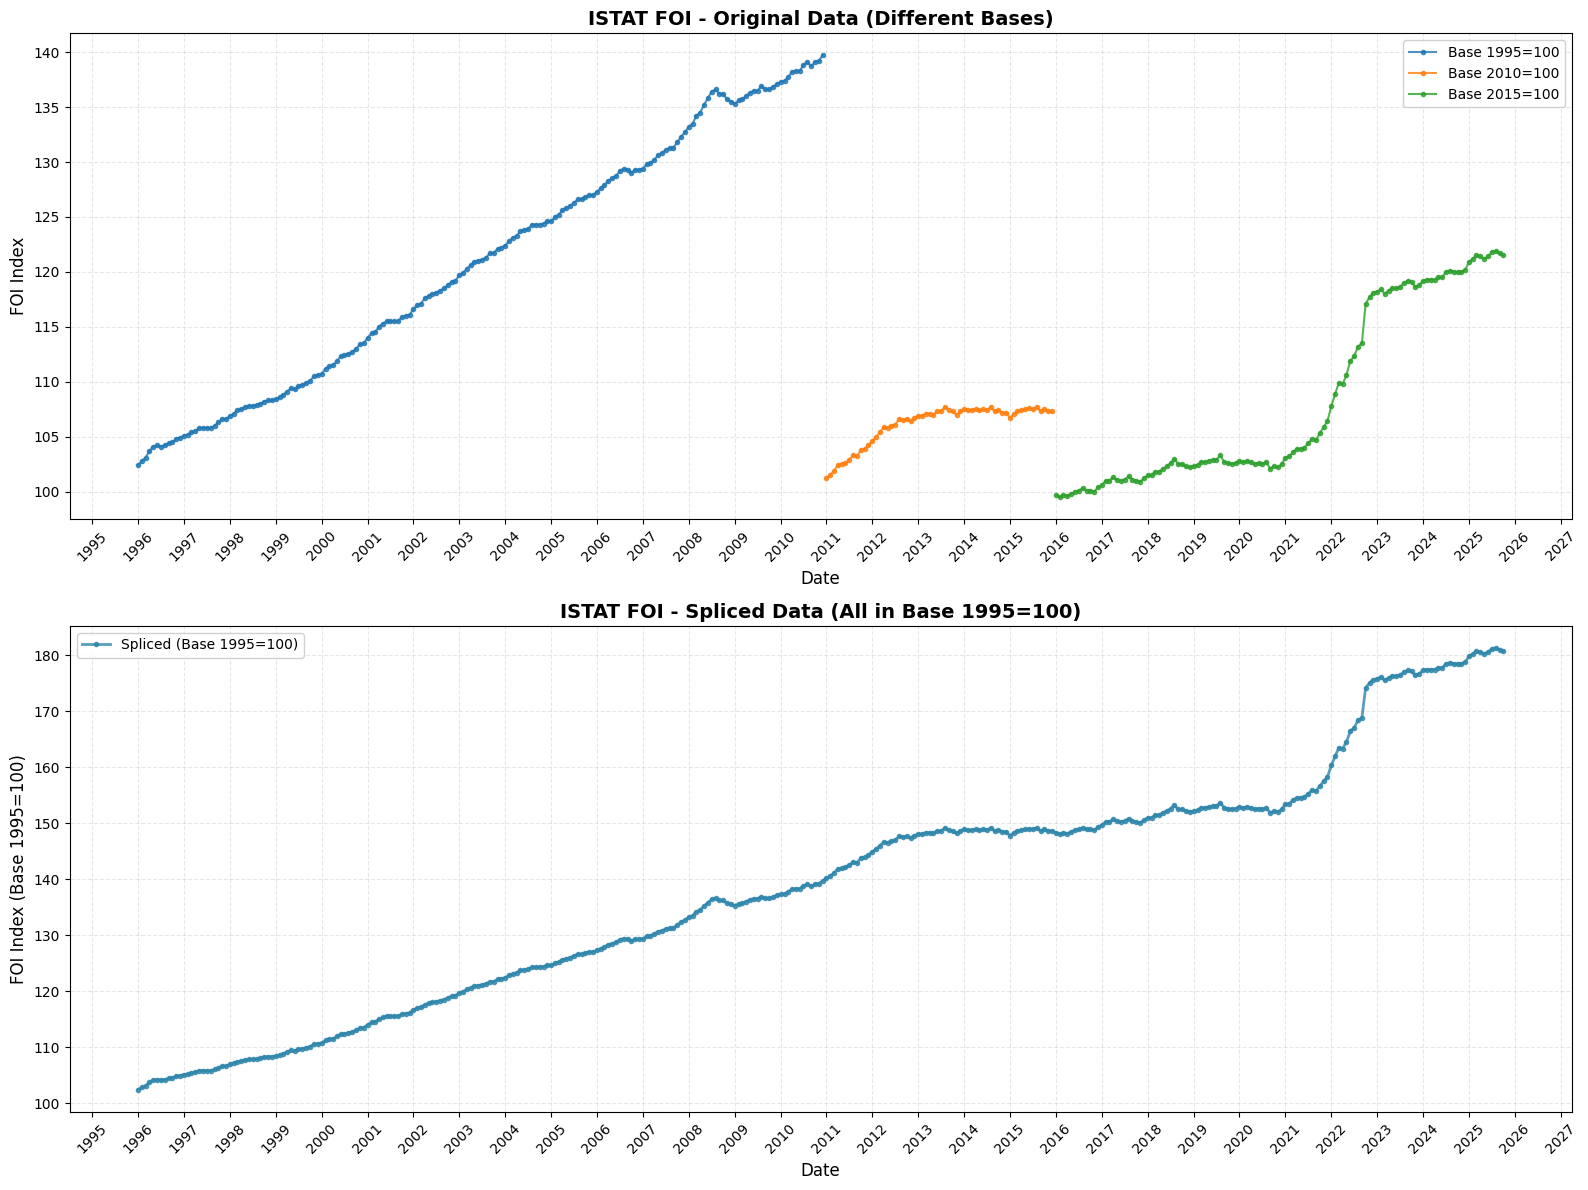

Comparative plot saved: data/istat/FOI_MONTHLY_comparative_plot.png


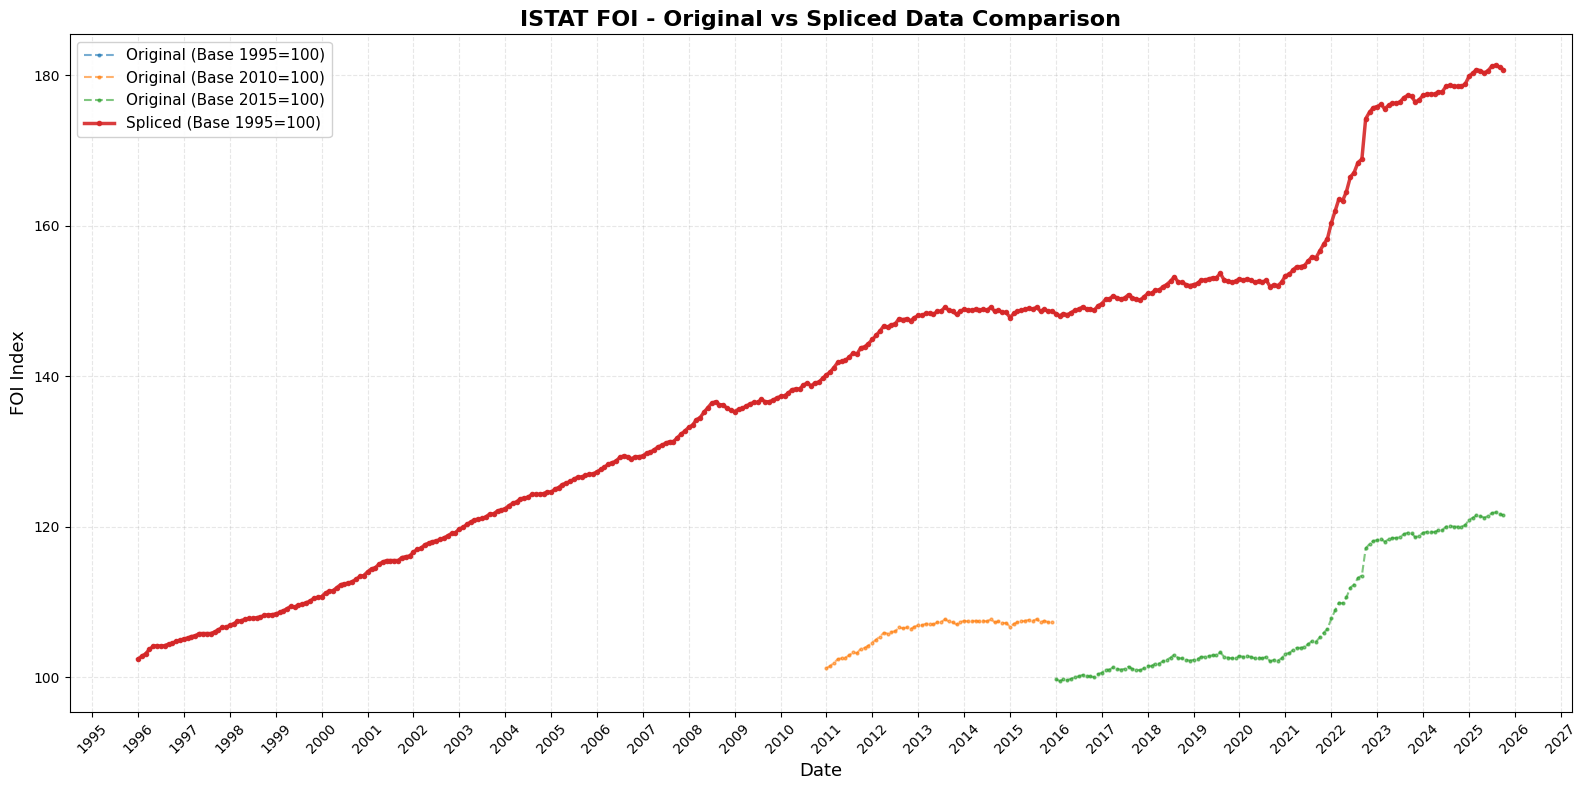


Plots created successfully!


In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Create plots
print(f"\n{'='*60}")
print("Creating plots...")
print(f"{'='*60}")

# Read the data files
df_original = pd.read_csv(os.path.join(output_dir, 'FOI_MONTHLY.csv'))
df_spliced = pd.read_csv(os.path.join(output_dir, 'FOI_MONTHLY_SPLICED.csv'))

# Convert TIME_PERIOD to datetime for plotting
df_original['DATE'] = pd.to_datetime(df_original['TIME_PERIOD'], format='%Y-%m')
df_spliced['DATE'] = pd.to_datetime(df_spliced['TIME_PERIOD'], format='%Y-%m')

# Plot 1: Original data with different bases
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot original data by base
ax1 = axes[0]
for base in df_original['BASE'].unique():
    df_base = df_original[df_original['BASE'] == base]
    ax1.plot(df_base['DATE'], df_base['OBS_VALUE'], 
             label=f'Base {base}', linewidth=1.5, alpha=0.8, marker='o', markersize=3)

ax1.set_title('ISTAT FOI - Original Data (Different Bases)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('FOI Index', fontsize=12)
ax1.legend(loc='best', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Plot spliced data (all in base 1995=100)
ax2 = axes[1]
ax2.plot(df_spliced['DATE'], df_spliced['OBS_VALUE'], 
         label='Spliced (Base 1995=100)', linewidth=2, color='#2E86AB', alpha=0.8, marker='o', markersize=3)

ax2.set_title('ISTAT FOI - Spliced Data (All in Base 1995=100)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('FOI Index (Base 1995=100)', fontsize=12)
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_major_locator(mdates.YearLocator(1))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

# Save the plot
plot_file = os.path.join(output_dir, 'FOI_MONTHLY_plots.png')
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"\nPlot saved: {plot_file}")

plt.show()

# Plot 2: Comparative plot (original vs spliced)
fig, ax = plt.subplots(figsize=(16, 8))

# Plot original data by base with different colors
colors = {'1995=100': '#1f77b4', '2010=100': '#ff7f0e', '2015=100': '#2ca02c'}
for base in df_original['BASE'].unique():
    df_base = df_original[df_original['BASE'] == base]
    ax.plot(df_base['DATE'], df_base['OBS_VALUE'], 
            label=f'Original (Base {base})', linewidth=1.5, alpha=0.6, 
            color=colors.get(base, 'gray'), linestyle='--', marker='o', markersize=2)

# Plot spliced data
ax.plot(df_spliced['DATE'], df_spliced['OBS_VALUE'], 
        label='Spliced (Base 1995=100)', linewidth=2.5, color='#d62728', alpha=0.9, marker='o', markersize=3)

ax.set_title('ISTAT FOI - Original vs Spliced Data Comparison', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('FOI Index', fontsize=13)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

# Save the comparative plot
plot_file_comparative = os.path.join(output_dir, 'FOI_MONTHLY_comparative_plot.png')
plt.savefig(plot_file_comparative, dpi=150, bbox_inches='tight')
print(f"Comparative plot saved: {plot_file_comparative}")

plt.show()

print(f"\n{'='*60}")
print("Plots created successfully!")
print(f"{'='*60}")


In [14]:
# Save the spliced file
if df_final is not None:
    output_file_spliced = os.path.join(output_dir, 'FOI_MONTHLY_SPLICED.csv')
    
    # Save to CSV
    df_final.to_csv(output_file_spliced, index=False)
    
    print(f"\n{'='*60}")
    print(f"File saved successfully: {output_file_spliced}")
    print(f"Dimensions: {len(df_final)} rows, {len(df_final.columns)} columns")
    print(f"All data converted to base 1995=100")
    print(f"{'='*60}")
else:
    print("No data to save!")



File saved successfully: data/istat/FOI_MONTHLY_SPLICED.csv
Dimensions: 358 rows, 2 columns
All data converted to base 1995=100
